In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [2]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
print(X.shape)
print(y.shape)

(150, 4)
(150,)


# SK-Learn PCA with k=2

In [4]:
pca = PCA(n_components=2, svd_solver='covariance_eigh')
X_sk_learn_pca = pca.fit_transform(X)

In [5]:
X_sk_learn_pca.shape

(150, 2)

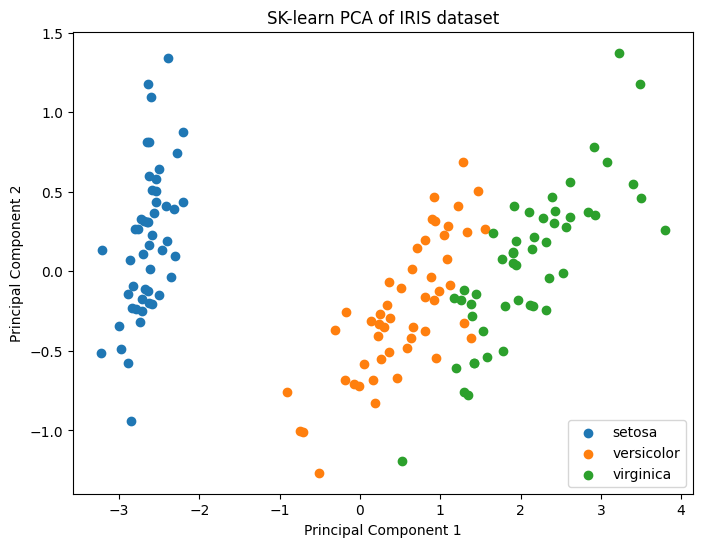

In [7]:
def plot_data(data_matrix: np.ndarray, data_labels: np.array):
    plt.figure(figsize=(8, 6))
    for target in set(data_labels):
        plt.scatter(data_matrix[data_labels == target, 0], data_matrix[data_labels == target, 1], label=iris.target_names[target])

    plt.title('SK-learn PCA of IRIS dataset')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# Plot the features outputted by PCA
plot_data(X_sk_learn_pca, y)

# PCA from scratch

### Compute covariance matrix

In [8]:
X.shape

(150, 4)

In [9]:
col_means = X.mean(axis=0)
x_hat = X - col_means

In [10]:
num_rows = x_hat.shape[0]

In [11]:
covariance_matrix = (x_hat.T @ x_hat) / (num_rows - 1)
covariance_matrix.shape

(4, 4)

In [12]:
covariance_matrix

array([[ 0.68569351, -0.042434  ,  1.27431544,  0.51627069],
       [-0.042434  ,  0.18997942, -0.32965638, -0.12163937],
       [ 1.27431544, -0.32965638,  3.11627785,  1.2956094 ],
       [ 0.51627069, -0.12163937,  1.2956094 ,  0.58100626]])

## Eigenvalue decomposition of the covariance matrix

To use only matrix-vector operations, we will use [Power iteration](https://en.wikipedia.org/wiki/Power_iteration) method to estimate eigenvectors of the covariance matrix.

In [13]:
def get_unit_length_random_vector(size: int):
    """Outputs unit length random vector"""
    random_vec = np.random.randn(size)
    random_vec = random_vec / np.linalg.norm(random_vec)  # normalize to unit length
    return random_vec

def get_eigen_vectors(matrix: np.ndarray, k: int = 2,
                      num_iterations: int = 1_000) -> np.ndarray:
    """
    Finds K number eigenvectors of a matrix using Power iteration method.
    After finding the first eigenvector, we find the second-largest
    eigenvector, then the third, etc, until find all the K eigenvectors of
    the matrix.

    Args:
        matrix:  matrix to find eigenvectors of
        k:  number of eigenvectors to find
        num_iterations:  number of iterations for the power iteration method

    Returns:
        Matrix of eigenvectors at its columns.
    """
    eigen_vectors = np.zeros((matrix.shape[1], k), dtype=np.float64)
    for i in tqdm(range(k)):
        init_vec = get_unit_length_random_vector(size=matrix.shape[1])
        for _ in tqdm(range(num_iterations)):  # Power iteration method loop
            init_vec = matrix @ init_vec
            init_vec = init_vec / np.linalg.norm(init_vec)  # back to unit length
            init_vec = subtract_projections(init_vec, eigen_vectors)  # subtract projections to find the next eigenvector

        eigen_vectors[:, i] = init_vec
    return eigen_vectors

def subtract_projections(vector: np.array, eigen_matrix: np.ndarray) -> np.array:
    """
    Subtracts projections of the input vector onto eigen_matrix columns from
    itself.
    This method is used by "get_eigen_vectors" function to compute K number of
    eigenvectors of a matrix.

    Args:
        vector: unit length vector
        eigen_matrix: contains unit length eigenvectors as columns

    Returns:
        new vector.
    """
    cos_theta = vector @ eigen_matrix  # gives cosines of angles between vectors, as all of them have unit length
    vec_projections = eigen_matrix @ np.diag(cos_theta)  # projection length of the vector onto the eigenvectors
    for i in range(vec_projections.shape[1]):
        vector = vector - vec_projections[:, i]
    vector = vector / np.linalg.norm(vector)  # rescale back to the unit length
    return vector

In [14]:
np.random.seed(42)
eigen_vecs = get_eigen_vectors(covariance_matrix, k=2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
eigen_vecs.shape

(4, 2)

In [16]:
numpy_eigenvalues, numpy_eigenvectors = np.linalg.eig(covariance_matrix)
assert np.allclose(numpy_eigenvectors[:, :2], eigen_vecs), "Values are not close enough!"

## Final step!
### Project data to the principal axes

In [17]:
new_data = x_hat @ eigen_vecs
# Below code will produce the same result:
# new_data = X @ (eigen_vecs)
# new_data = new_data - (col_means.reshape(1, -1) @ eigen_vecs)

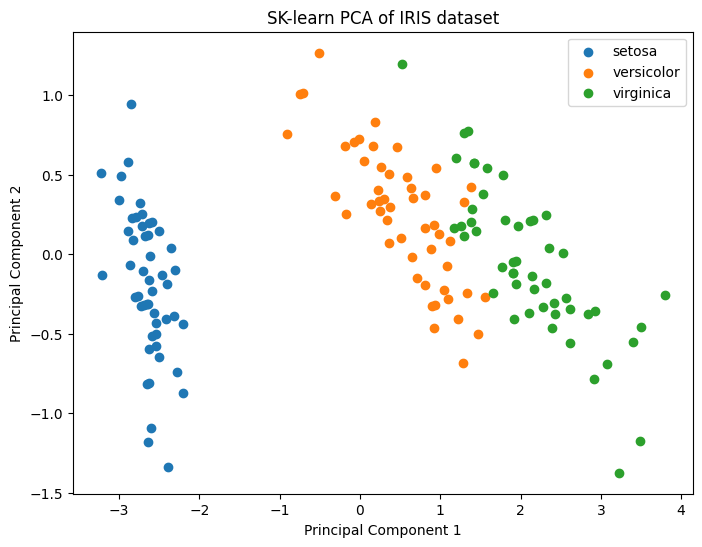

In [18]:
plot_data(new_data, y)

## We are almost there, but the result above is not similar to SK-Learn's implementation

It is because SK-Learn does additional operation on the eigenvectors, which do not change results, but may rotate data by 180 degrees for visualization purposes.

Sk-Learn changes the sings of coordinates of eigenvectors, so that the coordinate with the largest absolute value will always have a positive sign.

Let's implement this operation below:

# Make eigenvectors' values that are largest in absolute value to be positive

### To match results with the Sk-Learn's PCA

In [19]:
max_abs_idx = np.argmax(np.abs(eigen_vecs), axis=0)  # get max abs values index per column
signs = np.sign(eigen_vecs[max_abs_idx, range(eigen_vecs.shape[1])])  # get the signs
eigen_vecs = eigen_vecs * signs[np.newaxis, :]   # if negative max abs value, changed to positive

In [20]:
X_our_pca = x_hat @ eigen_vecs

In [21]:
assert np.allclose(X_our_pca, X_sk_learn_pca), "Values are not close enough!"

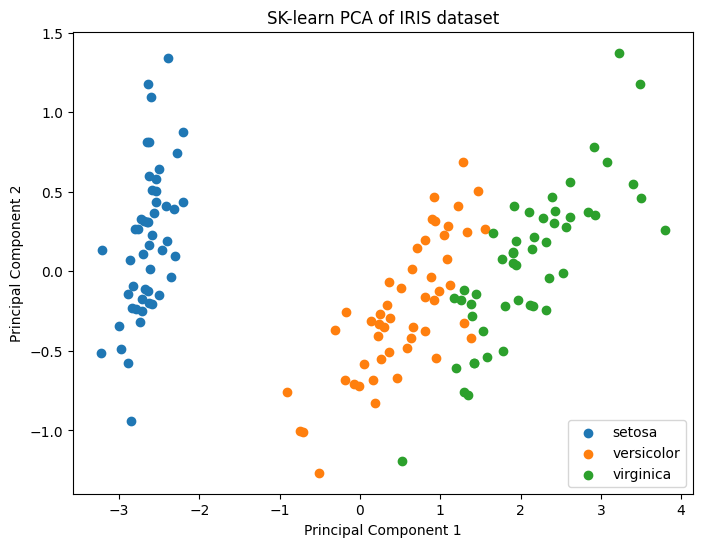

In [22]:
plot_data(X_our_pca, y)

# Now results do match exactly!

### Explained variance by the principal components (eigenvectors)

In [25]:
def plot_explained_variance(eigenvalues: np.array):
    eigenvalues = np.sort(eigenvalues)[::-1]  # sort in descending order
    cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(eigenvalues) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel("Number of Principal Components (k)")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Explained Variance vs. Number of Components")
    plt.grid()
    plt.show()

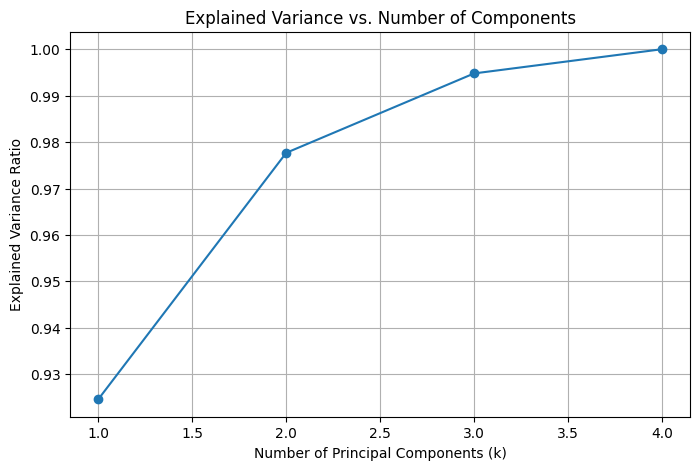

In [26]:
plot_explained_variance(numpy_eigenvalues)

### LDA code below is not finished!!!

## LDA

In [21]:
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        total_data = X.shape[0]
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            n_c = X_c.shape[0]
            SW += (X_c - mean_c).T.dot((X_c - mean_c)) * n_c / total_data 
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += (mean_diff).dot(mean_diff.T) * n_c / total_data

        # Determine SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        # store first n eigenvectors
        self.linear_discriminants = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        return np.dot(X, self.linear_discriminants.T)


In [22]:
X.shape

(150, 4)

In [23]:
# Project the data onto the 2 primary linear discriminants
lda = LDA(2)
lda.fit(X, y)
X_LDA_projected = lda.transform(X)

In [24]:
print("Shape of X:", X.shape)
print("Shape of transformed X:", X_LDA_projected.shape)

Shape of X: (150, 4)
Shape of transformed X: (150, 2)


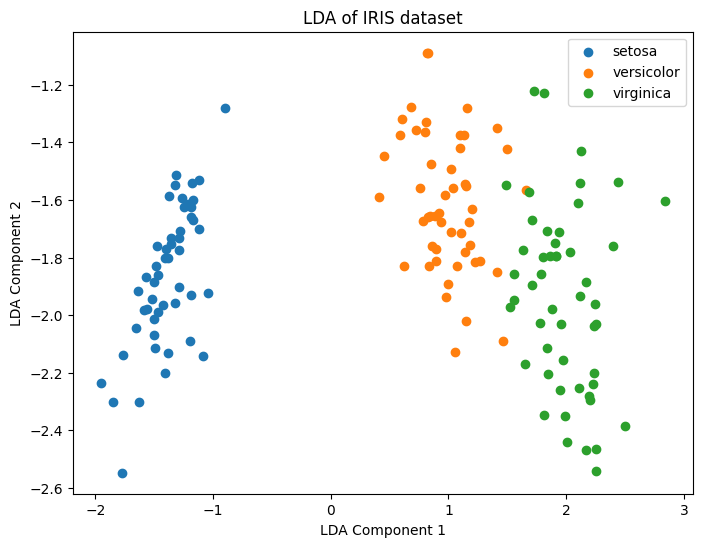

In [25]:
# Plot the features outputted by PCA
plt.figure(figsize=(8, 6))
for target in set(y):
    plt.scatter(X_LDA_projected[y == target, 0], X_LDA_projected[y == target, 1], label=iris.target_names[target])

plt.title('LDA of IRIS dataset')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend()
plt.show()

# KNN Clustering results

KNN Clustering with LDA versus PCA (not finished)